Summary of my results:

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 3.355085 | 4.272877 | 0.382089 | 0.291899
\+ teacher forcing | 3.154585 |	4.022432 | 0.407792 | 0.310715
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Seq2Seq Translation with Attention

Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

A nice illustration of attention comes from [this blog post](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar (visualization originally from [Tensor2Tensor notebook](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)):

<img src="images/alammar-attention.png" alt="attention" style="width: 60%"/>

A second things that might help is to use a bidirectional model for the encoder. We set the `bidrectional` parameter to `True` for our GRU encoder, and double the number of inputs to the linear output layer of the encoder.

Also, we now need to set our hidden state:

```
hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))
```

### Code to re-run from start

In [3]:
from fastai.text import *

In [2]:
path = Config().data_path()

In [10]:
path = 'C:/Users/zuzan/Data Science/polish_bert/chat-bot/'

In [4]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0])],res_y[i,:len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [5]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [7]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [27]:
data = load_data(path, num_workers=0)

In [11]:
model_path = Config().model_path()

In [12]:
emb_enc = torch.load(os.path.join(path, 'emb_enc.pth'))
emb_dec = torch.load(os.path.join(path, 'emb_dec.pth'))

In [13]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [14]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [15]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [16]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [17]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [18]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [19]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        #probability of forcing decrease with epoch number 
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        #average of 4 precisions - unigrams ... 4-grams
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [20]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
         #probability of forcing decrease with epoch number 
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

### Implementing attention

In [134]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
  
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        #take the embedding prepared for encoder (input texts)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        #put that into first GRU, we want the hiddent state and embedding that we put into encoder
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        #biderictional; double hidden state
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        #put that in linear layer and return final hidden state
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        #apply linear layer, dropout
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
       
  #put input into encoder then in a for loop you feed decoder   
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        #put the batch size and the input into a encoder, get out the hidden state
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        #define decoder input size
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            #decoder input and hidden state into decocer, get out hidden state and output
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
             #if we have padding - break
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
                #else return results
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))
    #2 hidden layers, 300 dim of embedding, 64 batch size

```
hid=torch.Size([2, 64, 300])
dec_inp=torch.Size([64])
enc_att=torch.Size([64, 30, 300])
hid_att=torch.Size([64, 300])
u=torch.Size([64, 30, 300])
attn_wgts=torch.Size([64, 30])
enc_out=torch.Size([64, 30, 512])
ctx=torch.Size([64, 512])
emb=torch.Size([64, 300])
```

In [135]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


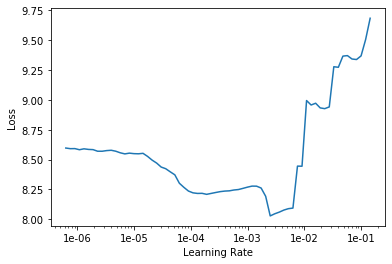

In [136]:
learn.lr_find()
learn.recorder.plot()

In [130]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


KeyboardInterrupt: 

In [ ]:
inputs, targets, outputs_argmax = get_predictions(learn)

In [114]:
#inputs[700], targets[700], outputs[700]

In [115]:
#inputs[701], targets[701], outputs[701]

In [116]:
#inputs[4002], targets[4002], outputs[4002]

In [117]:
#inputs[2001], targets[2001], outputs[2001]

In [118]:
#df = pd.DataFrame(list(zip(inputs, targets, outputs)), 
#               columns =['inputs', 'targets', 'outputs']) 

In [119]:
#df
#df.to_csv('preds.csv', encoding = 'utf-8')
#df = pd.read_csv("preds.csv")
#df

In [120]:
#outputs

In [123]:
from random import choice

def select_nucleus(outp, p=0.5):
    probs = F.softmax(outp,dim=-1)
    idxs = torch.argsort(probs, descending=True)
    res,cumsum = [],0.
    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum>p: return idxs.new_tensor([choice(res)])

def decode(self, inp):
    inp = inp[None]
    bs, sl = inp.size()
    hid,enc_out = self.encoder(bs, inp)
    dec_inp = inp.new_zeros(bs).long() + self.bos_idx
    enc_att = self.enc_att(enc_out)

    res = []
    for i in range(self.out_sl):
        hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
        dec_inp = select_nucleus(outp[0], p=0.3)
#         dec_inp = select_topk(outp[0], k=2)
        res.append(dec_inp)
        if (dec_inp==self.pad_idx).all(): break
    return torch.cat(res)

def predict_with_decode(learn, x, y):
    learn.model.eval()
    ds = learn.data.train_ds
    with torch.no_grad():
        out = decode(learn.model, x)
        rz = ds.y.reconstruct(out)
    return rz

def preds_acts(learn, ds_type=DatasetType.Valid):
    "Same as `get_predictions` but also returns non-reconstructed activations"
    learn.model.eval()
    ds = learn.data.train_ds
    inputs,targets,outputs = [],[],[] 
    outs = []
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            for x,y in zip(xb,yb):
                inputs.append(ds.x.reconstruct(x))
                targets.append(ds.y.reconstruct(y))
                outputs.append(predict_with_decode(learn, x, y))
    return inputs,targets,outputs

In [124]:
rx,ry,rz = preds_acts(learn)
rz

[Text xxbos nie chyba , że coś nie , , że nie to , ale,
 Text xxbos tak tak ,,
 Text xxbos no w sumie nie wiem xxunk,
 Text xxbos xxunk xxunk xxunk , nie xxunk xxunk,
 Text xxbos jak , , że , że nie nie xxunk,
 Text xxbos czyli które są ? ? a ja xxunk xxunk , bo nie wiem co tam,
 Text xxbos nie nie , , , ale na xxunk ,,
 Text xxbos oh zz,
 Text xxbos nie wiem co xxunk znaczy,
 Text xxbos a jak xxunk to ?,
 Text xxbos :),
 Text xxbos ale to nie jest tak xxunk,
 Text xxbos xxunk nie wiem co co jest ,,
 Text xxbos to tak xxunk,
 Text xxbos nie w tej pory,
 Text xxbos ja się nie xxunk , ale chyba nie jest dobrze,
 Text xxbos tak,
 Text xxbos nie nie wiem co,
 Text xxbos to jest to jak tam ?,
 Text xxbos to to jest,
 Text xxbos nie xxunk xxunk,
 Text xxbos xxunk się,
 Text xxbos nie ,,
 Text xxbos xxunk,
 Text xxbos xxunk to , że to,
 Text xxbos to trochę nie xxunk xxunk , że się xxunk , że się xxunk , ale , xxunk na niej w ogóle , ale w xxunk się xxunk , ale,
 Text xxbos oh , , ale się nie

In [126]:
df_beam = pd.DataFrame(list(zip(rx,ry,outputs_argmax,rz)), 
               columns =['inputs', 'targets','outputs_argmax', 'outputs']) 
df_beam.to_csv('preds_beam.csv', encoding = 'utf-8')
df_beam = pd.read_csv("preds_beam.csv")
df_beam

,Unnamed: 0,inputs,targets,outputs_argmax,outputs
0,0,"xxbos xxunk , że to bardzo xxunk historia , al...",xxbos to piękna historia ♥ czy 2 x nie wiem to...,"xxbos nie , że nie xxunk","xxbos nie chyba , że coś nie , , że nie to , ale"
1,1,xxbos zycie to udawanie bo dots trzyma zespolo...,xxbos a jak to zrobiłaś ? to z xxunk,"xxbos tak tak , nie jest tak","xxbos tak tak ,"
2,2,xxbos gdzie xxunk xxunk ? xxunk niemcy z xxunk...,"xxbos nie jestem pewien , czy akurat dlatego t...",xxbos to nawet w xxunk xxunk xxunk xxunk,xxbos no w sumie nie wiem xxunk
3,3,xxbos jeszcze żadna xxunk xxunk nie xxunk mnie...,xxbos też potrafią być xxunk . ostatnio słysza...,xxbos xxunk xxunk xxunk xxunk xxunk xxunk,"xxbos xxunk xxunk xxunk , nie xxunk xxunk"
4,4,"xxbos ah , tylko przez okno . zastanawiałam si...","xxbos zawsze wiedziałem , że w nocy xxunk chod...","xxbos tak , , że xxunk","xxbos jak , , że , że nie nie xxunk"
5,5,"xxbos mialam dosc xxunk dzien , tez xxunk nie ...","xxbos ludzie nie rozumieją xxunk do słońca , i...",xxbos i oni też xxunk xxunk xxunk xxunk xxunk ...,"xxbos czyli które są ? ? a ja xxunk xxunk , bo..."
6,6,xxbos wzięłam xxunk do pracy i xxunk go wokół ...,xxbos ^^ gram sobie chciałam xxunk jakąś xxunk...,"xxbos nie , , ale nie , ale nie , że xxunk","xxbos nie nie , , , ale na xxunk ,"
7,7,xxbos nie mogę sobie xxunk xxunk życia no i ma...,xxbos to dlaczego każą ci w nim coś robić ? bo...,xxbos oh zz,xxbos oh zz
8,8,xxbos 🐥 pytałem o ludzi z iz - tu sa jakby dwi...,xxbos y xxrep 4 e aaa będę chodziła na pwr na ...,xxbos nie wiem czy xxunk xxunk,xxbos nie wiem co xxunk znaczy
9,9,xxbos eee nie pytaj tak sobie musze robic pwr ...,xxbos eee,xxbos a to,xxbos a jak xxunk to ?


In [102]:
rx[780], rz[780]

(Text xxbos chciałam zanieść papier do xxunk no dobrze myslałem , że coś innego się wydarzyło mieli dla ciebie pracę ?,
 Text xxbos xxunk xxunk xxunk , ale xxunk xxunk się trochę się cieszę)